In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_SEED=25

In [25]:
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

In [26]:
df.head()

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Length_Minutes,IMDB_Rating
0,24 Hour Party People,2002,7,R,Biography|Comedy|Drama|Music,Michael Winterbottom,117,7.3
1,28 Days Later,2002,53,R,Horror|Sci-Fi|Thriller,Danny Boyle,113,7.6
2,28 Weeks Later,2007,212,R,Horror|Sci-Fi|Thriller,Juan Carlos Fresnadillo,100,7.0
3,30 Days of Night,2007,67,R,Horror|Thriller,David Slade,113,6.6
4,300,2007,600,R,Action|Fantasy|History|War,Zack Snyder,117,7.7


In [27]:
# Homework 2, I
# Choost 3-6 features, explain
# Apply k-means at k=5, k=9
# In both cases take 10 or more random inits, choose the best over the K-means criterion
# Homework 2, II
# Take one partition
# Compare one of the features between two clusters using bootstrap
# Take a feature, find 95% confidence interval for grand mean using bootstrap
# Take a cluster, compare the grand mean with the within-cluster mean for the feature by using bootstrap
# Note: each application of bootstrap sohuld be done inboth pivotal and non-pivotal versions

In [28]:
quant_features = ['Body_Count', 'Length_Minutes', 'Year']

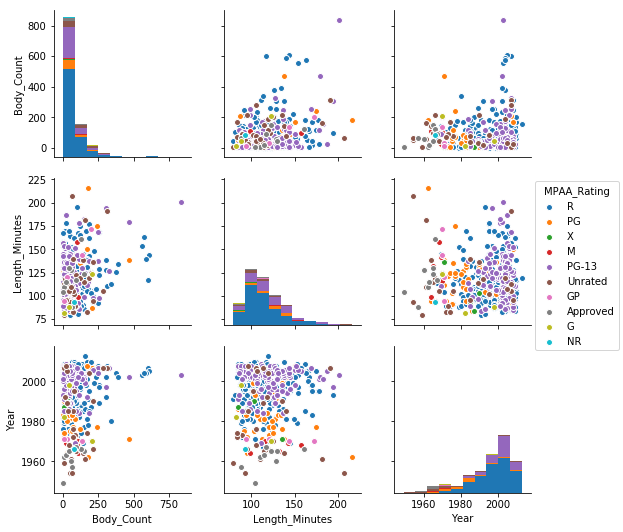

In [29]:
sns.pairplot(df, hue='MPAA_Rating', vars=quant_features)

In [30]:
def normalize(vec):
    # center by mean, normalize by range
    return (vec - vec.mean())/(vec.max() - vec.min())

   Body_Count  Length_Minutes  Year  Approved  G  GP  M  NR  PG  PG-13  R  \
0           7             117  2002         0  0   0  0   0   0      0  1   
1          53             113  2002         0  0   0  0   0   0      0  1   
2         212             100  2007         0  0   0  0   0   0      0  1   
3          67             113  2007         0  0   0  0   0   0      0  1   
4         600             117  2007         0  0   0  0   0   0      0  1   

   Unrated  X  
0        0  0  
1        0  0  
2        0  0  
3        0  0  
4        0  0  


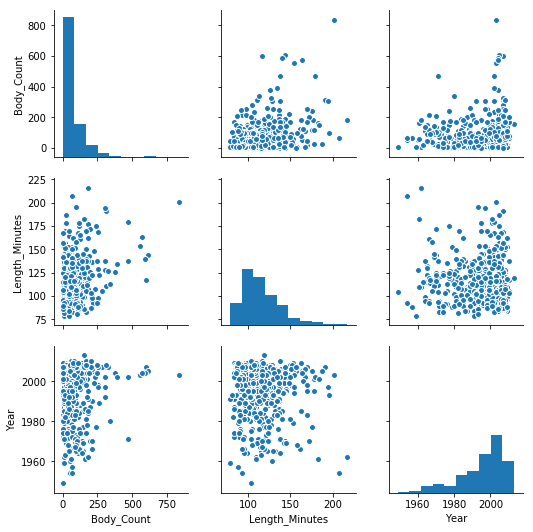

In [31]:
# K-means
features = quant_features+['MPAA_Rating']
task_df = pd.DataFrame(df[features])
#task_df['MPAA_Rating_dummy']
task_df = pd.concat([task_df, pd.get_dummies(task_df['MPAA_Rating'])], axis=1)
task_df = task_df.drop('MPAA_Rating', axis=1)
print(task_df.head())
sns.pairplot(task_df, vars=quant_features)

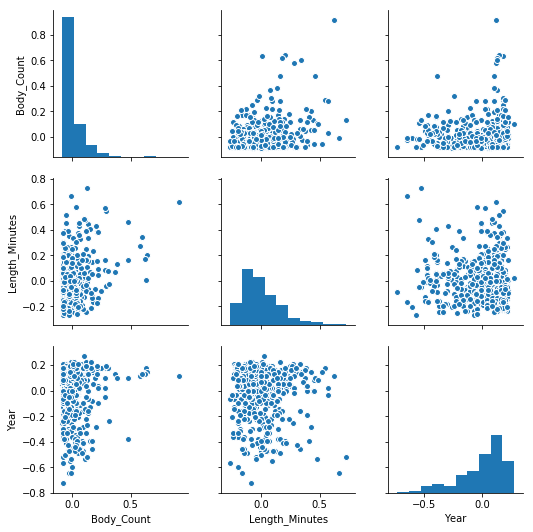

In [32]:
task_df = normalize(task_df)
sns.pairplot(task_df, vars=quant_features)

Sum of squared distances from points to cluster centers, k=5: 65.09974068146857


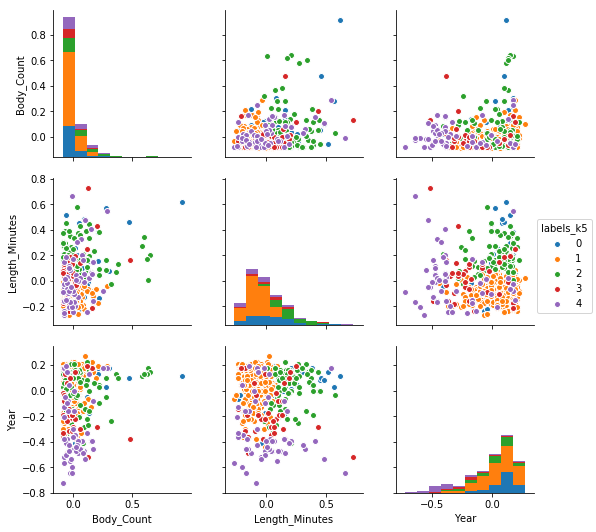

In [33]:
# Kmeans, k = 5
kmeans_k5 = KMeans(n_clusters=5, init='random', n_init=10, random_state=RANDOM_SEED) # kmeans, random initialization, 10 random inits, choose best by kmeans criterion
kmeans_k5.fit(task_df)
task_df['labels_k5'] = pd.Series(kmeans_k5.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=5:', kmeans_k5.inertia_)
sns.pairplot(task_df, hue='labels_k5', vars=quant_features)

Sum of squared distances from points to cluster centers, k=9: 41.69861742938954


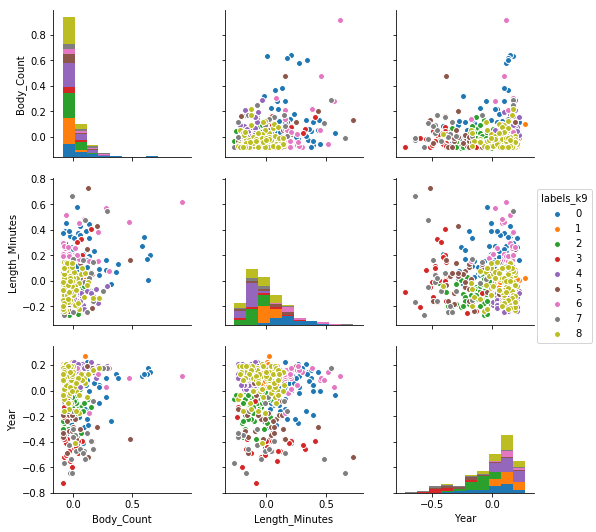

In [34]:
# Kmeans, k = 9
kmeans = KMeans(n_clusters=9, init='random', n_init=10, random_state=RANDOM_SEED) # kmeans, random initialization, 10 random inits, choose best by kmeans criterion
kmeans.fit(task_df)
task_df['labels_k9'] = pd.Series(kmeans.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=9:', kmeans.inertia_)
sns.pairplot(task_df, hue='labels_k9', vars=quant_features)

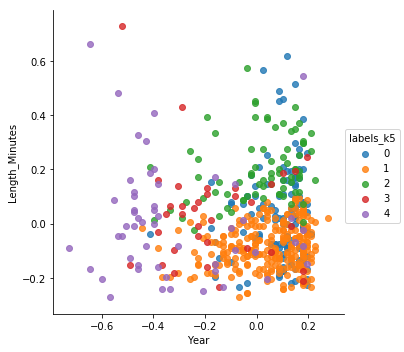

In [35]:
# Consider the patrition obtained for
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df, hue='labels_k5')

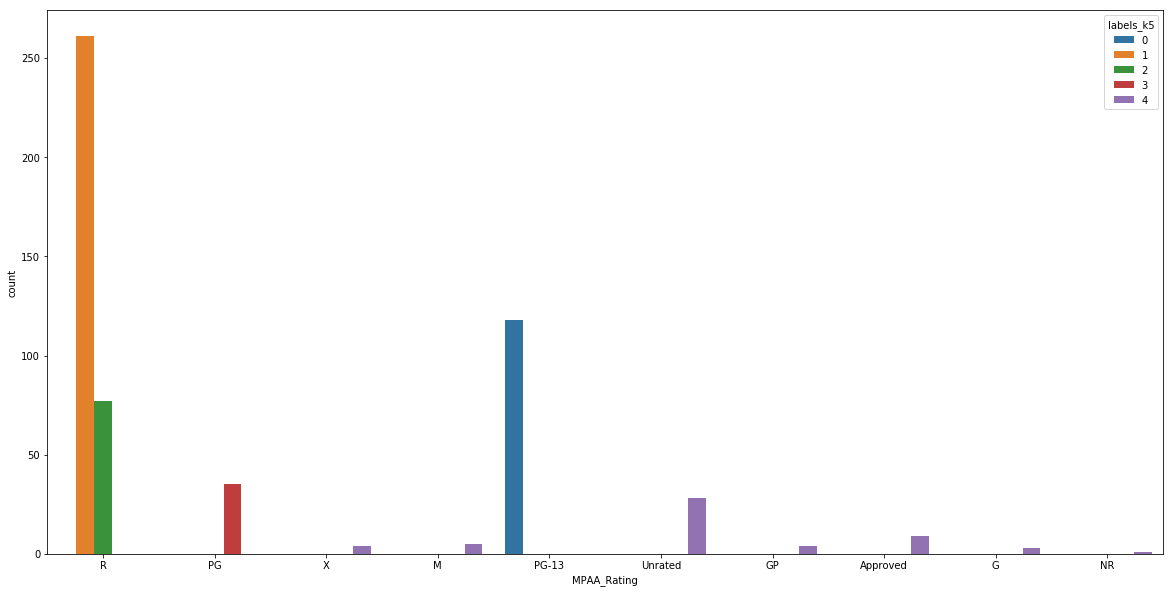

In [146]:
df['labels_k5'] = task_df['labels_k5']
fig = plt.figure(figsize=(20,10))
sns.countplot(x='MPAA_Rating', hue='labels_k5', data=df)
# Interpretation:
# Cluster 0 basically contains PG-13 (low body count) movies, cluster 1 contains mostly R movies.

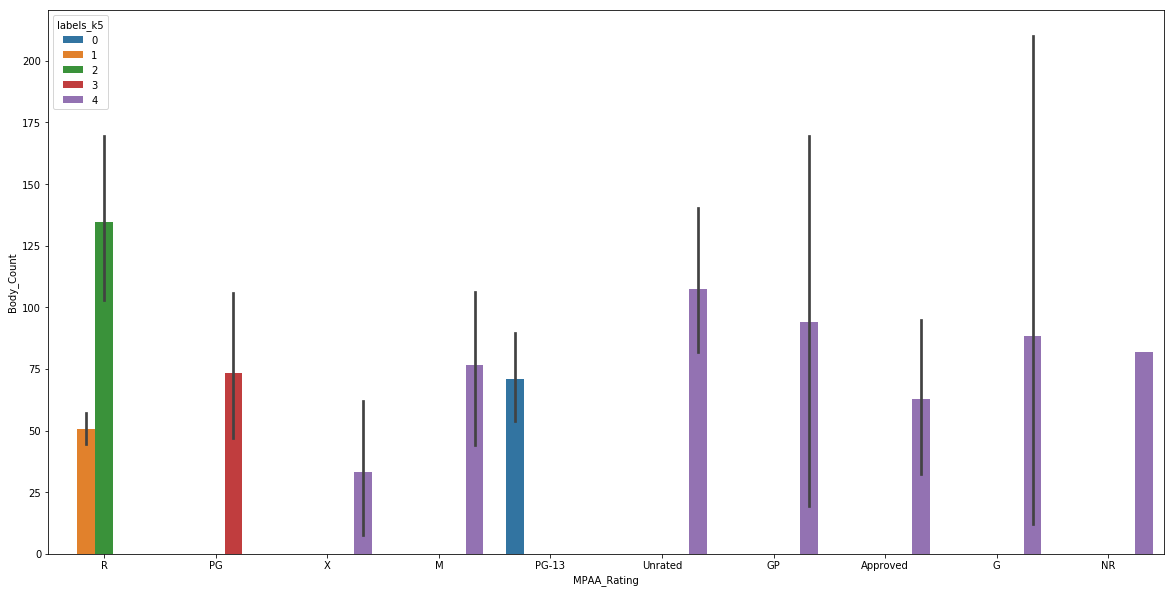

In [148]:
fig = plt.figure(figsize=(20,10))
sns.barplot(x='MPAA_Rating', y='Body_Count', hue='labels_k5', data=df)
# Interpretation:
# Clearly cluster 2 contains the highest body count movies, even among R rated ones
# Cluster 3 contains most PG movies with medium body count
# Cluster 4 consists of all movie ratings that are underrepresented in the dataset

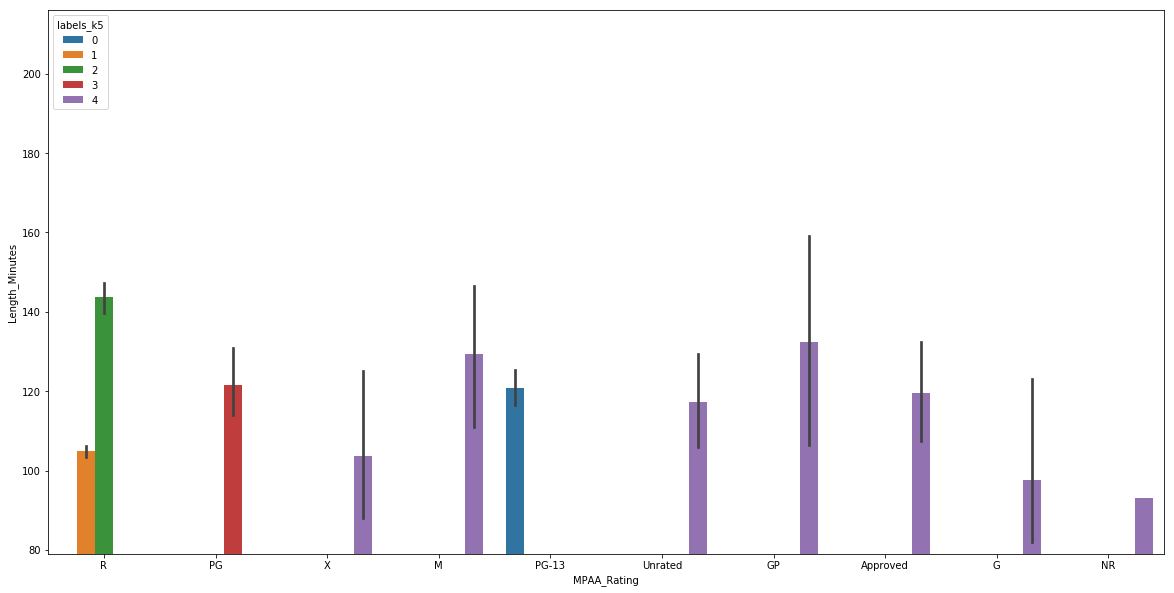

In [155]:
fig = plt.figure(figsize=(20,10))
plt.ylim(bottom=df.Length_Minutes.min(), top = df.Length_Minutes.max())
sns.barplot(x='MPAA_Rating', y='Length_Minutes', hue='labels_k5', data=df)
# Mean Length is basically same amoung clusters

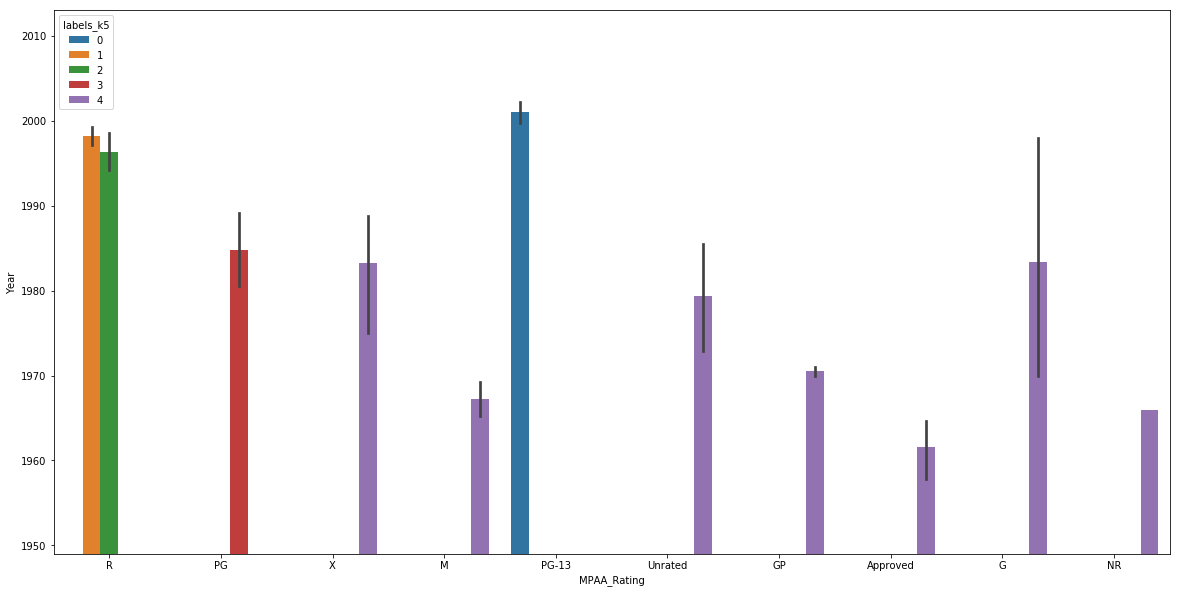

In [154]:
fig = plt.figure(figsize=(20,10))
plt.ylim(bottom=df.Year.min(), top = df.Year.max())
sns.barplot(x='MPAA_Rating', y='Year', hue='labels_k5', data=df)
# Length barely affects anything, it's more or less same among movies
# Seems like cluster 0 is mostly about very recent movies. IN general high body count movies are modern, low body count are old. 
# There are, however, outliers, as evident by the bar of cluster G

In [36]:
task_df.labels_k5.value_counts()

1    261
0    118
2     77
4     54
3     35
Name: labels_k5, dtype: int64

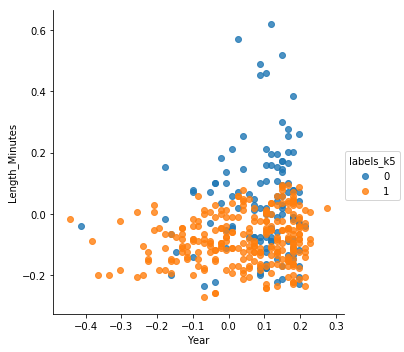

In [37]:
cluster_0 = df[task_df['labels_k5'] == 0]
cluster_1 = df[task_df['labels_k5'] == 1]
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df[(task_df['labels_k5'] == 0)|(task_df['labels_k5'] == 1)], hue='labels_k5')

In [113]:
target_feature = 'Body_Count'

count    118.000000
mean      70.906780
std      103.396836
min        3.000000
25%       11.250000
50%       45.500000
75%       88.500000
max      836.000000
Name: Body_Count, dtype: float64

count    261.000000
mean      50.559387
std       50.369799
min        1.000000
25%       15.000000
50%       34.000000
75%       73.000000
max      310.000000
Name: Body_Count, dtype: float64


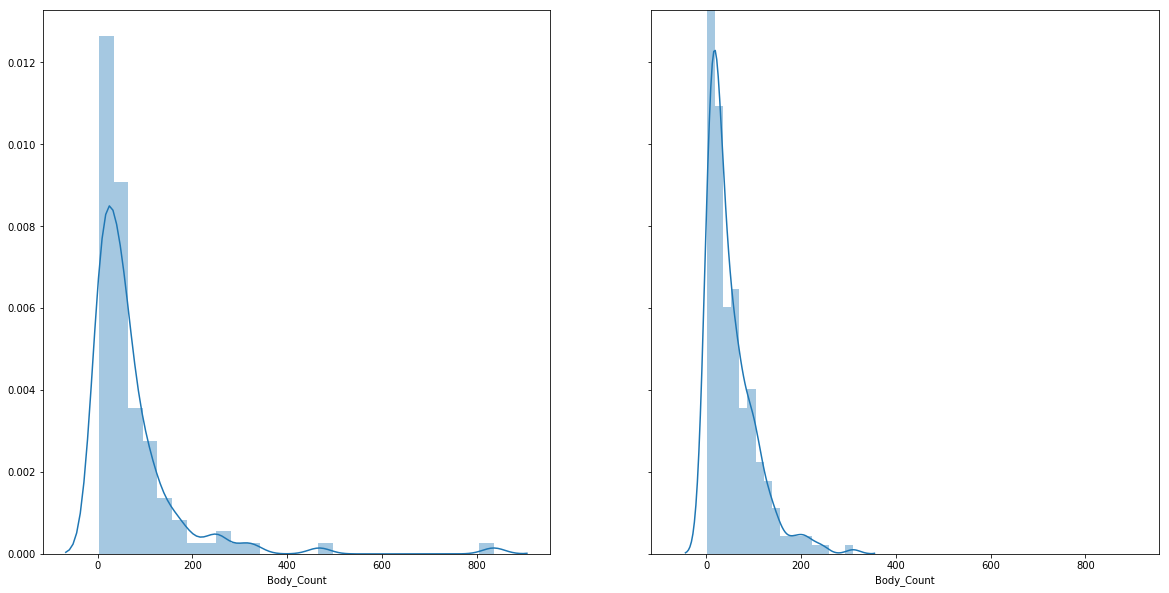

In [117]:
print(cluster_0[target_feature].describe())
print()
print(cluster_1[target_feature].describe())
# Top movie by body count, apparently
#cluster_0[cluster_0.Body_Count == cluster_0.Body_Count.max()]
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)

sns.distplot(cluster_0.Body_Count, ax=axes[0])
sns.distplot(cluster_1.Body_Count, ax=axes[1])

In [118]:
def bootstrap_sample(vec, size):
    return np.random.choice(vec, size=(vec.shape[0], size), replace=True)

def bootstrap_means(srs, sample_amount=5000):
    samples_ix = bootstrap_sample(srs.index, size=sample_amount).T
    means = np.array([srs.loc[sample].mean() for sample in samples_ix])
    return means

95% confidence intervals
For cluster 0
pivotal [52.62079076342596, 89.4439990670825]
non pivotal [54.45720338983051, 90.8989406779661]

For cluster 1
pivotal [44.278109185445956, 56.814638707274355]
non pivotal [44.394444444444446, 56.76273946360153]


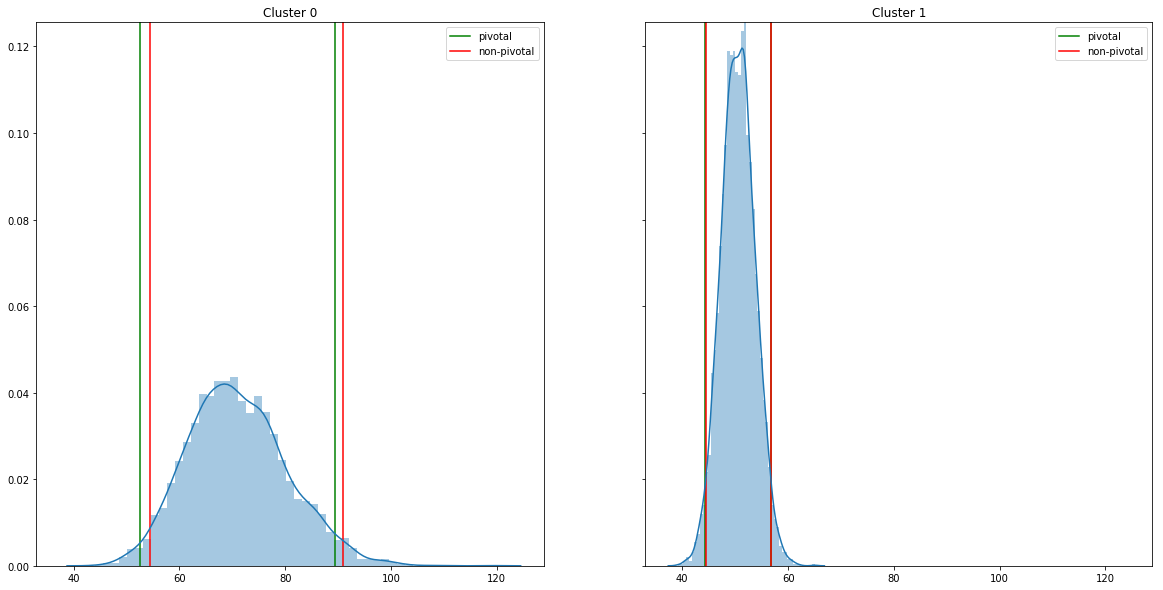

In [131]:
b_means_cluster_0 = bootstrap_means(cluster_0.Body_Count)
b_means_cluster_1 = bootstrap_means(cluster_1.Body_Count)

def confidence_interval_pivotal(vec):
    mean = vec.mean()
    std = vec.std()
    return [mean-1.96*std, mean+1.96*std]

def confidence_interval_non_pivotal(vec, alpha):
    left = np.percentile(vec, (100-alpha)/2)
    right = np.percentile(vec, alpha+(100-alpha)/2)
    #print(len(vec), int((alpha+(100-alpha)/2)*len(vec)))
    #print(np.sort(vec)[int((alpha+(100-alpha)/2)*len(vec))])
    return [left, right]

def distplot_with_conf_intervals(vec, ax=None):
    if not ax:
        ax = plt.gca()
    for x in confidence_interval_pivotal(vec):
        line = ax.axvline(x=x, color='g')
    line.set_label('pivotal')
    for x in confidence_interval_non_pivotal(vec, 95):
        line = ax.axvline(x=x, color='r')
    line.set_label('non-pivotal')
    ax.legend(loc='best')
    return sns.distplot(vec, ax=ax, norm_hist=False)

print('95% confidence intervals')
print('For cluster 0')
print('pivotal', confidence_interval_pivotal(b_means_cluster_0))
print('non pivotal', confidence_interval_non_pivotal(b_means_cluster_0, 95))
print()
print('For cluster 1')
print('pivotal', confidence_interval_pivotal(b_means_cluster_1))
print('non pivotal', confidence_interval_non_pivotal(b_means_cluster_1, 95))

# The gaussian, pivotal version, looks better. I dunno.

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
axes[0].set_title('Cluster 0')
distplot_with_conf_intervals(b_means_cluster_0, ax=axes[0])
axes[1].set_title('Cluster 1')
distplot_with_conf_intervals(b_means_cluster_1, ax=axes[1])

95% confidence intervals
For the grand mean
pivotal [64.07371025195994, 80.05940020675567]
non pivotal [64.4145871559633, 80.05743119266053]

For cluster 0
pivotal [51.84183102935464, 89.70627066556062]
non pivotal [54.15233050847458, 91.341313559322]


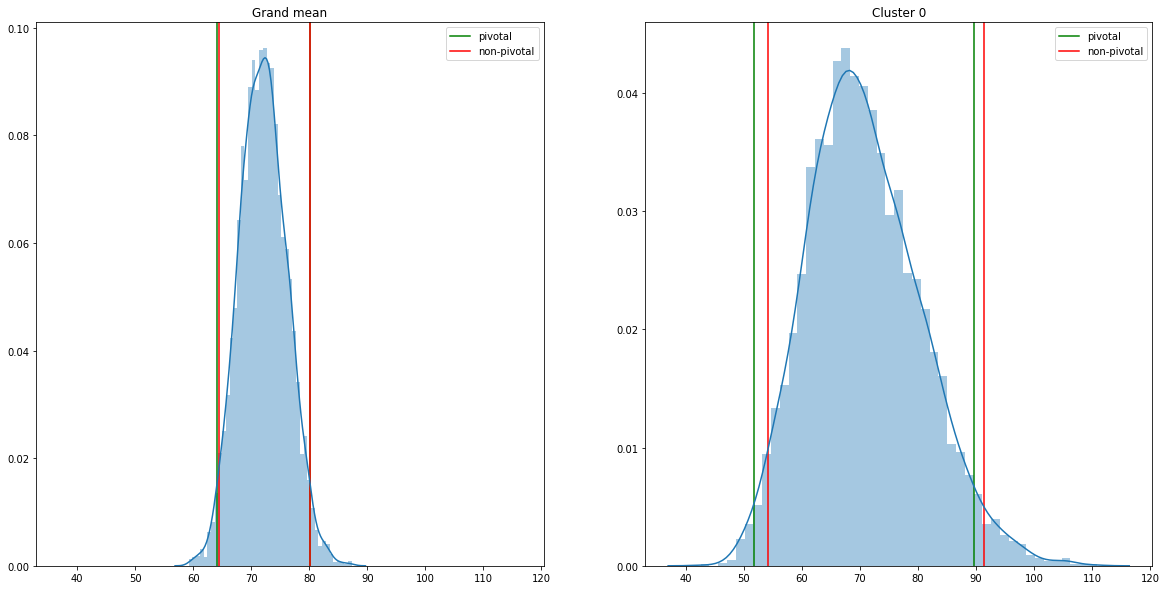

In [130]:
grand_mean_b_samples = bootstrap_means(df.Body_Count)
print('95% confidence intervals')
print('For the grand mean')
print('pivotal', confidence_interval_pivotal(grand_mean_b_samples))
print('non pivotal', confidence_interval_non_pivotal(grand_mean_b_samples, 95))
print()
print('For cluster 0')
print('pivotal', confidence_interval_pivotal(b_means_cluster_0))
print('non pivotal', confidence_interval_non_pivotal(b_means_cluster_0, 95))
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True)
axes[0].set_title('Grand mean')
distplot_with_conf_intervals(grand_mean_b_samples, ax=axes[0])
axes[1].set_title('Cluster 0')
distplot_with_conf_intervals(b_means_cluster_0, ax=axes[1])